<a href="https://colab.research.google.com/github/Justinezgh/muse/blob/main/notebook/Check_FullField_mcmc_LogNormal_Lensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install --quiet jax-cosmo
!pip install --quiet numpyro
!pip install --quiet dm-haiku
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet chainconsumer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 KB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
%pylab inline

from functools import partial 
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import haiku as hk

master_seed = hk.PRNGSequence(42)

from chainconsumer import ChainConsumer

from sbi_lens.simulator.LogNormal_field import (
    make_power_map,
    shift_fn, 
    make_lognormal_power_map
)

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [ ]:
%load_ext autoreload
%autoreload 2

#Model

In [3]:
def lensingLogNormal(N=128,
                     map_size=5,
                     gal_per_arcmin2=10,
                     sigma_e=0.26,
                     model_type='lognormal',
                     with_noise=True, 
                     non_gaussianity = 1):
  """
  Calculate Log-Normal lensing convergence map.
  -----------
  N: int
  Number of pixels on the map.

  map_size: int
  The total angular size area is given by map_size x map_size

  gal_per_arcmin2: int
  Number of galaxies per arcmin


  sigma_e : float
  Dispersion of the ellipticity distribution

  model_type: string
  Physcal model adopted for the simulations

  with_noise : boolean
  If True Gaussian noise will be added to the lensing map

  Returns
  -------
  x: Jax.DeviceArray (N,N)
  Lensing convergence map
  """

  pix_area = (map_size * 60 / N)**2
  map_size = map_size / 180 * jnp.pi

  omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
  sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05))

  cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
  pz = jc.redshift.smail_nz(0.5, 2., 1.0)
  tracer = jc.probes.WeakLensing([pz])
  ell_tab = jnp.logspace(0, 4.5, 128) 
  cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
  P = lambda k: jc.scipy.interpolate.interp(
      k.flatten(), ell_tab, cell_tab
  ).reshape(k.shape)

  z = numpyro.sample(
      'z',
      dist.MultivariateNormal(
          loc=jnp.zeros((N, N)),
          precision_matrix= jnp.eye(N)
      )
  )

  power_map = make_power_map(P, N, map_size)

  if model_type == 'lognormal':
    shift = non_gaussianity
    power_map = make_lognormal_power_map(power_map, shift)
  field = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
  if model_type == 'lognormal':
    field = shift * (jnp.exp(field - jnp.var(field) / 2) - 1)

  if with_noise == True:

    x = numpyro.sample(
        'y',
        dist.Independent(
            dist.Normal(field, sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)),
            2
        )
    ) 
  else:
    x = numpyro.deterministic('y', field)

  return x

In [7]:
# define lensing model

N=100
map_size=5
gal_per_arcmin2=30
sigma_e=0.2
model_type='lognormal' 
non_gaussianity=0.01

model = partial(lensingLogNormal,
                N=N,
                map_size=map_size,
                gal_per_arcmin2=gal_per_arcmin2,
                sigma_e=sigma_e,
                model_type=model_type, 
                non_gaussianity=non_gaussianity,
                with_noise=True
)

In [8]:
m_data = jnp.load('/content/m_data.npy')

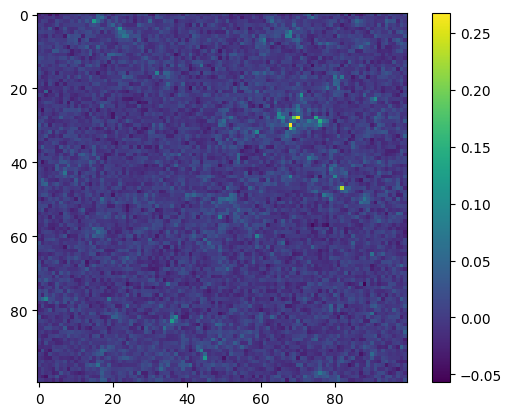

In [9]:
imshow(m_data); colorbar();

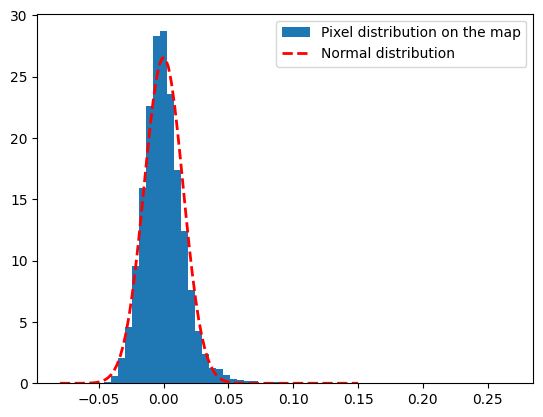

In [31]:
hist(
    m_data.reshape([-1]), 
     60, 
     density = True, 
     label = 'Pixel distribution on the map'
);

x = jnp.linspace(-0.08, 0.15, 100)
plot(
     x, 
     tfd.Normal(0, 0.015).prob(x), 
     '--', 
     color = 'red', 
     linewidth = '2', 
     label = 'Normal distribution'
)
legend()

/usr/local/lib/python3.9/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.9/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://git

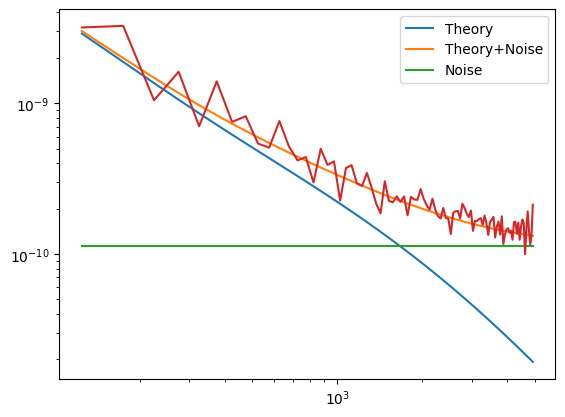

In [32]:
# check power spectrum
import lenstools as lt
import astropy.units as u

cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
# Creating a given redshift distribution
gal_per_arcmin2=30
pz = jc.redshift.smail_nz(0.5, 2., 1.0, gals_per_arcmin2=gal_per_arcmin2)
tracer = jc.probes.WeakLensing([pz], sigma_e=sigma_e)
f_sky= map_size**2/41_253

kmap_lt = lt.ConvergenceMap(m_data, map_size*u.deg)
l_edges = np.arange(100.0,5000.0,50.0)
l2,Pl2 = kmap_lt.powerSpectrum(l_edges)

cell = jc.angular_cl.angular_cl(cosmo, l2, [tracer])[0]
cell_noise = jc.angular_cl.noise_cl(l2, [tracer])[0]
_, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, l2, [tracer], f_sky=f_sky)

loglog(l2, cell, label='Theory')
loglog(l2, cell + cell_noise, label='Theory+Noise')
loglog(l2, cell_noise, label='Noise')
loglog(l2, Pl2)
legend()

# Check MCMC

In [33]:
# get mcmcs samples

field = jnp.load('/content/z.npy')
params = jnp.load('/content/posterior.npy')

In [45]:
@jax.vmap
@jax.jit
def get_map(params, field):

  cond_model = condition(
      model, 
      {'omega_c': params[0], 'sigma_8':  params[1], 'z': field})

  sample_map_fiducial = seed(cond_model, jax.random.PRNGKey(42))

  return sample_map_fiducial()

In [48]:
res = get_map(params[:1000], field[:1000])

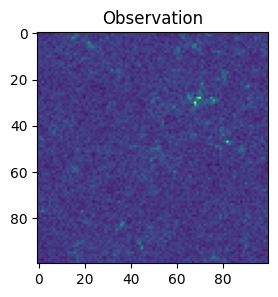

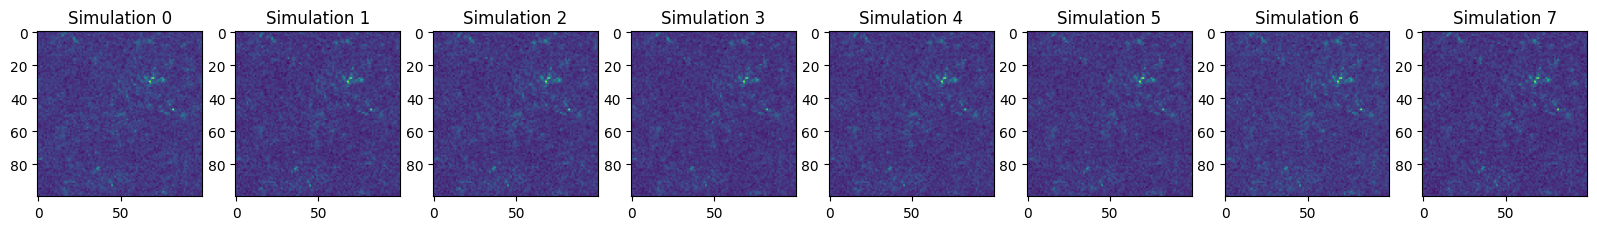

In [88]:
figure(figsize = (3, 3))
imshow(m_data)
title('Observation')

fig, axs = plt.subplots(1, 8, figsize=(20, 5))

for i in range(8):
  axs[i].imshow(res[i])
  axs[i].set_title('Simulation %d' %i)

Text(0.5, 1.0, 'Difference between 2 simulated maps')

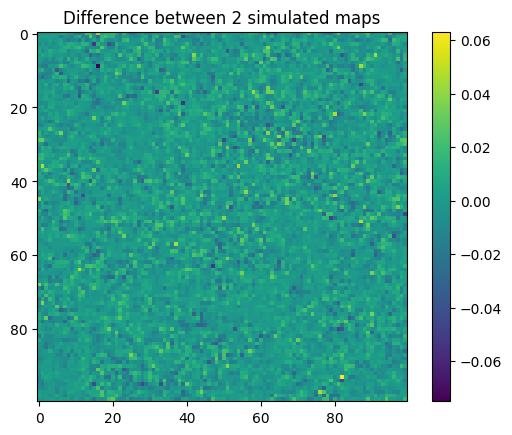

In [86]:
imshow(res[0]-res[1]); colorbar();
title('Difference between 2 simulated maps')